# Test notebook to evolve one single planet & plot its radius evolution

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import constants as const

# remove this line if you installed platypos with pip
sys.path.append("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/github/github_May21/platypos/")
import platypos
from platypos import Planet_LoFo14
from platypos import Planet_ChRo16
from platypos import Planet_Ot20
import platypos.planet_models_LoFo14 as plmoLoFo14
import platypos.planet_models_ChRo16 as plmoChRo16

# Create Planet object and stellar evolutionary track

## Example planet 1.1 - V1298Tau c with 5 Eearth mass core and measured radius (var. step)

In [4]:
# (David et al. 2019, Chandra observation)
L_bol, mass_star, radius_star = 0.934, 1.101, 1.345 # solar units
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV)
Lx_age_error = 1.4e29

# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}

Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27
track_low = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}
track_med = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track_high = {"t_start": star_V1298Tau["age"], "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}

track = track_med

# planet c
planet = {"core_mass": 5.0, "radius": 5.59, "distance": 0.0825, "metallicity": "solarZ"}

pl = Planet_LoFo14(star_V1298Tau, planet)
#pl.__dict__

## Example planet 1.2 - V1298Tau c with mass estimate from Otegi et al. (2020) and measured radius (var step)

In [133]:
pl = Planet_Ot20(star_V1298Tau, planet)
#pl.__dict__

## Example planet 2 - artificial planet with specified core mass and envelope mass fraction (Comparison LoFo & ChRo models)

In [8]:
Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27

dict_star = {'star_id': 'dummy',
 'mass': 1.0, 'radius': None,
 'age': 10., 'L_bol': 1.0, 'Lx_age': 1.5e+30}

dict_pl = {'distance': 0.13, 'fenv': 8.0, 'core_mass': 5.0}

Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27
track = {"t_start": 10., "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": dict_star["Lx_age"], 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}

pl = Planet_LoFo14(dict_star, dict_pl)
pl_ = Planet_ChRo16(dict_star, dict_pl)
#pl.__dict__

# Evolve & create outputs

In [9]:
%%time

folder_id = "LoFo"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=1.0e5, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='Johnstone',
                                         mass_loss_calc='Elim',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)
df_pl = pl.read_results(path_save)

###############################################################################
try:
    folder_id = "ChRo"
    path_save_ = os.path.join(os.getcwd(), folder_id+"/")
    if not os.path.exists(path_save_):
        os.makedirs(path_save_)
    else:
        os.system("rm -r " + path_save_[:-1])
        os.makedirs(path_save_)

    beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
    pl_.evolve_forward_and_create_full_output(t_final=1.0e5, initial_step_size=0.1,
                                             epsilon=0.1, K_on="yes",
                                             relation_EUV='Johnstone',
                                             mass_loss_calc='Elim',
                                             fenv_sample_cut=False,
                                             beta_settings=beta_settings,
                                             evo_track_dict=track,
                                             path_for_saving=path_save_,
                                             planet_folder_id=folder_id)

    df_pl_ = pl_.read_results(path_save_)
except:
    pass

CPU times: user 22.7 s, sys: 39.1 ms, total: 22.7 s
Wall time: 22.7 s


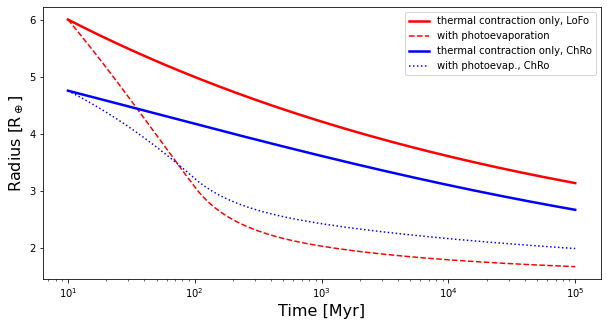

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

# LoFo planet
ax.plot(df_pl["Time"], plmoLoFo14.calculate_planet_radius(pl.core_mass, pl.fenv, df_pl["Time"], pl.flux, pl.metallicity), \
        lw=2.5, label='thermal contraction only, LoFo', color="red")
ax.plot(df_pl["Time"], df_pl["Radius"], 
        marker="None", ls="--", label='with photoevaporation', color="red")

try:
    # ChRo planet
    ax.plot(df_pl_["Time"], plmoChRo16.calculate_planet_radius(pl_.core_mass, pl_.fenv, pl_.flux, df_pl_["Time"]), \
            lw=2.5, label='thermal contraction only, ChRo', color="blue")
    ax.plot(df_pl_["Time"], df_pl_["Radius"], marker="None", ls=":", label='with photoevap., ChRo', color="blue")
except:
    pass
    
ax.legend(fontsize=10)
ax.set_xlabel("Time [Myr]", fontsize=16)
ax.set_ylabel("Radius [R$_\oplus$]", fontsize=16)
ax.set_xscale('log')
#ax.set_ylim(5.15, 5.62)
plt.show()

# Example Comparison of EUV estimation relation

In [33]:
%%time

folder_id = "SanzForcada2011_EUV"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

tf = 3.0e4
beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=tf, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='SanzForcada',
                                         mass_loss_calc='Elim',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track_high,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)

df_pl_SF = pl.read_results(path_save)

###
folder_id = "Linsky2015_EUV"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=tf, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='Linsky',
                                         mass_loss_calc='Elim',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track_high,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)
df_pl_LI = pl.read_results(path_save)

###
folder_id = "Johnstone2020_EUV"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=tf, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='Johnstone',
                                         mass_loss_calc='Elim',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track_high,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)

df_pl_JO = pl.read_results(path_save)

CPU times: user 3.7 s, sys: 7.82 ms, total: 3.71 s
Wall time: 3.71 s


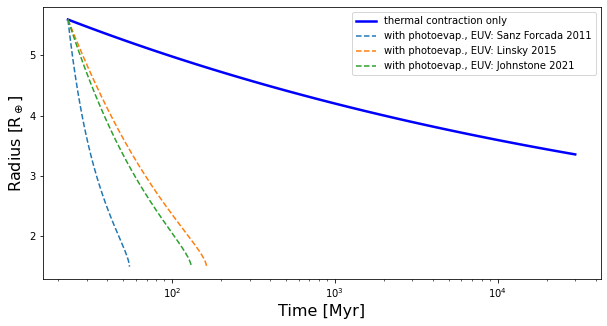

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
age_arr = np.logspace(np.log10(pl.age), np.log10(tf), 100)


label_names = iter(["Sanz Forcada 2011", "Linsky 2015", "Johnstone 2021"])

if (type(pl) == platypos.planet_LoFo14.Planet_LoFo14
        or type(pl) == platypos.planet_LoFo14_PAPER.Planet_LoFo14_PAPER):
    ax.plot(age_arr, plmoLoFo14.calculate_planet_radius(pl.core_mass, pl.fenv, age_arr, pl.flux, pl.metallicity), \
            lw=2.5, label='thermal contraction only', color="blue")
    
    for df_pl in [df_pl_SF, df_pl_LI, df_pl_JO]:
        ax.plot(df_pl["Time"], df_pl["Radius"], 
                marker="None", ls="--", label='with photoevap., EUV: ' + next(label_names))
else:
    for df_pl in [df_pl_SF, df_pl_LI, df_pl_JO]:
        ax.plot(df_pl["Time"], df_pl["Radius"], marker="None", ls="--", label='with photoevaporation', color="red")

ax.legend(fontsize=10)
ax.set_xlabel("Time [Myr]", fontsize=16)
ax.set_ylabel("Radius [R$_\oplus$]", fontsize=16)
ax.set_xscale('log')
#ax.set_ylim(5.15, 5.62)
plt.show()

# Example Comparison of mass-loss rate calculations

In [36]:
%%time

folder_id = "Elim"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

tf = 3.0e4
beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=tf, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='Johnstone',
                                         mass_loss_calc='Elim',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track_high,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)

df_pl_E = pl.read_results(path_save)

###
folder_id = "Elim_and_RRlim"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=tf, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='Johnstone',
                                         mass_loss_calc='Elim_and_RRlim',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track_high,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)
df_pl_ER = pl.read_results(path_save)

###
folder_id = "HBA"
path_save = os.path.join(os.getcwd(), folder_id+"/")
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

beta_settings = {"beta_calc": "Salz16", "RL_cut": True, "beta_cut": False}
pl.evolve_forward_and_create_full_output(t_final=tf, initial_step_size=0.1,
                                         epsilon=0.1, K_on="yes",
                                         relation_EUV='Johnstone',
                                         mass_loss_calc='HBA',
                                         fenv_sample_cut=False,
                                         beta_settings=beta_settings,
                                         evo_track_dict=track_high,
                                         path_for_saving=path_save,
                                         planet_folder_id=folder_id)

df_pl_HBA = pl.read_results(path_save)

CPU times: user 2.91 s, sys: 15.8 ms, total: 2.93 s
Wall time: 2.94 s


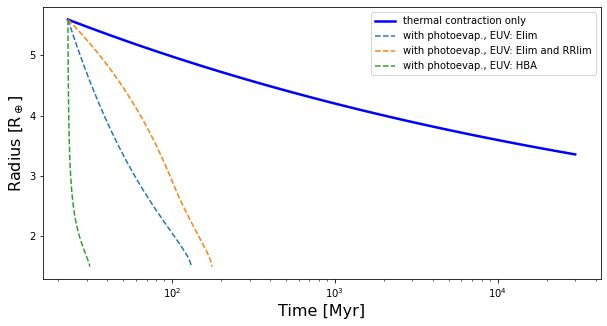

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
age_arr = np.logspace(np.log10(pl.age), np.log10(tf), 100)


label_names = iter(["Elim", "Elim and RRlim", "HBA"])

if (type(pl) == platypos.planet_LoFo14.Planet_LoFo14
        or type(pl) == platypos.planet_LoFo14_PAPER.Planet_LoFo14_PAPER):
    ax.plot(age_arr, plmoLoFo14.calculate_planet_radius(pl.core_mass, pl.fenv, age_arr, pl.flux, pl.metallicity), \
            lw=2.5, label='thermal contraction only', color="blue")
    
    for df_pl in [df_pl_E, df_pl_ER, df_pl_HBA]:
        ax.plot(df_pl["Time"], df_pl["Radius"], 
                marker="None", ls="--", label='with photoevap., EUV: ' + next(label_names))
else:
    for df_pl in [df_pl_E, df_pl_ER, df_pl_HBA]:
        ax.plot(df_pl["Time"], df_pl["Radius"], marker="None", ls="--", label='with photoevaporation', color="red")

ax.legend(fontsize=10)
ax.set_xlabel("Time [Myr]", fontsize=16)
ax.set_ylabel("Radius [R$_\oplus$]", fontsize=16)
ax.set_xscale('log')
#ax.set_ylim(5.15, 5.62)
plt.show()